# Experiment 2: CNN for Digit Classification (PyTorch)

We will build a **Convolutional Neural Network (CNN)** to classify handwritten digits **0–9** using the **`sklearn` digits** dataset (8×8 grayscale images).

**Lab rule:** code cells are intentionally short so you can **type each cell in ~2 minutes or less**.


## 1) Import libraries
Type these imports once. We will reuse them in all later cells.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
#!Conda install sklearn - ML 
from sklearn.datasets import load_digits # Load dataset
from sklearn.model_selection import train_test_split # Split dataset for 70% for training
from sklearn.metrics import confusion_matrix, classification_report # Check how your model learned

import torch # This is pytorch - For Deep learning models - Tensorflow
import torch.nn as nn # All NN Models are pre-defined 
import torch.optim as optim # Optimization - SGD 
from torch.utils.data import TensorDataset, DataLoader # Load data to GPU/RAM

## 2) Load the dataset
`X` holds images, `y` holds labels. Each image is **8×8**.


In [2]:
digits = load_digits()
X = digits.images # Input images
y = digits.target # Target Lables

X.shape, y.shape

((1797, 8, 8), (1797,))

## 3) Look at a few examples
This gives you a feel for what the model will see as input.


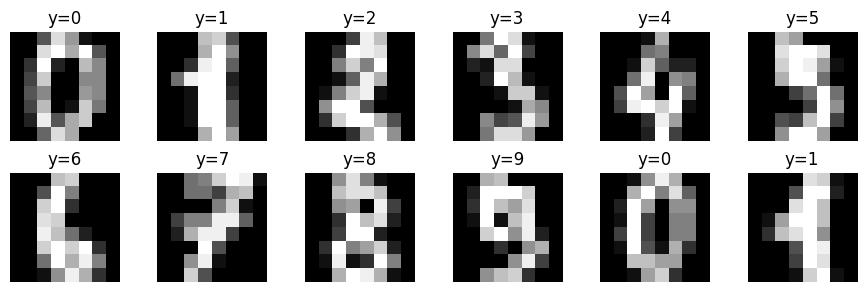

In [3]:
fig, axes = plt.subplots(2, 6, figsize=(9, 3))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(X[i], cmap="gray")
    ax.set_title(f"y={y[i]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

## 4) Normalize + add channel dimension
- Pixel values range **0–16**, so divide by 16 to get **0–1**.
- CNN input shape should be **(batch, channels, height, width)**, so we add `channels=1`.


In [4]:
X = (X / 16.0).astype(np.float32) # Divide each image by max value
X = X[:, None, :, :]   # add channel dimension - Remember

X.shape # previous shape of X - 1797,8,8
#X[1] # black pixel - 0, white - 16/255

(1797, 1, 8, 8)

## 5) Train–test split
We keep 20% data for testing. `stratify=y` keeps digit counts balanced.


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((1437, 1, 8, 8), (360, 1, 8, 8))

## 6) Convert to PyTorch tensors
Neural networks in PyTorch work with `torch.Tensor`.


In [6]:
X_train = torch.tensor(X_train, dtype=torch.float32) # Training images
X_test  = torch.tensor(X_test,  dtype=torch.float32) # Testing Images

y_train = torch.tensor(y_train, dtype=torch.long) # Training labels
y_test  = torch.tensor(y_test,  dtype=torch.long) # Test labels

## 7) Create DataLoaders
DataLoaders give mini-batches for faster training.


In [7]:
batch_size = 64 # 32,16,8,4,2,1,128,256

train_loader = DataLoader(TensorDataset(X_train, y_train),
                          batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test,  y_test),
                          batch_size=batch_size, shuffle=False)

## 8) Choose CPU/GPU
The code runs on CPU, but will use GPU automatically if available.


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 9) CNN Part 1: Feature extractor
This part learns **image features** using Conv/ReLU/Pool.


In [9]:
feature_extractor = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),                 # 8x8 -> 4x4
    nn.Conv2d(16, 32, kernel_size=3, padding=1),
    nn.ReLU()
)
# Check with more filters more layers and kernel_size = 5/7/11/13/17

## 10) CNN Part 2: Classifier
This part converts features into **10 class scores** (0–9).


In [10]:
classifier = nn.Sequential(
    nn.Flatten(),                    # 32x4x4 -> 512
    nn.Linear(32 * 4 * 4, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 10)
)

## 11) Combine parts into one model
`nn.Sequential` lets us connect modules end-to-end.


In [11]:
model = nn.Sequential(feature_extractor, classifier).to(device)
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
  )
  (1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=512, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

## 12) Quick output-shape check
A batch should produce output of shape `(batch_size, 10)`.


In [13]:
images, labels = next(iter(train_loader))
logits = model(images.to(device))
logits.shape

torch.Size([64, 10])

## 13) Count trainable parameters
A quick way to understand model size.


In [14]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
trainable_params

38282

## 14) Loss + optimizer
- `CrossEntropyLoss` = standard for multi-class classification.
- `Adam` = popular optimizer.


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 15) One function to run an epoch
Same function can train or evaluate.
- If `train=True`, it runs backprop.
- If `train=False`, it only measures loss/accuracy.


In [17]:
def run_epoch(model, loader, criterion, optimizer=None, train=False):
    model.train(train)
    total_loss = correct = total = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        if train: optimizer.zero_grad()
        logits = model(x); loss = criterion(logits, y)
        if train: loss.backward(); optimizer.step()
        total_loss += loss.item() * y.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    return total_loss / total, correct / total


## 16) Train for a few epochs
Watch how loss goes down and accuracy goes up.


In [18]:
torch.manual_seed(0)
np.random.seed(0)
epochs = 5  # increase later (e.g., 10) if you want higher accuracy

for epoch in range(1, epochs + 1):
    tr_loss, tr_acc = run_epoch(model, train_loader, criterion, optimizer, train=True)
    te_loss, te_acc = run_epoch(model, test_loader,  criterion, train=False)

    print(f"Epoch {epoch:02d} | train acc {tr_acc:.3f} | test acc {te_acc:.3f}")


Epoch 01 | train acc 0.295 | test acc 0.647
Epoch 02 | train acc 0.577 | test acc 0.783
Epoch 03 | train acc 0.708 | test acc 0.897
Epoch 04 | train acc 0.817 | test acc 0.908
Epoch 05 | train acc 0.866 | test acc 0.908


## 17) Get predictions on the test set
We collect `y_true` and `y_pred` for metrics and plots.


In [19]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for x, y in test_loader:
        preds = model(x.to(device)).argmax(1).cpu()
        y_true.append(y)
        y_pred.append(preds)

y_true = torch.cat(y_true).numpy()
y_pred = torch.cat(y_pred).numpy()


## 18) Confusion matrix
Shows which digits are being confused with others.


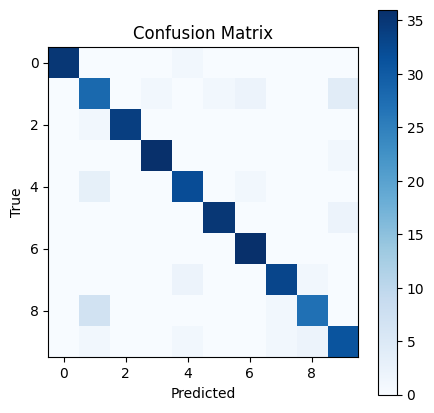

array([[35,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0, 28,  0,  1,  0,  1,  2,  0,  0,  4],
       [ 0,  1, 34,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 36,  0,  0,  0,  0,  0,  1],
       [ 0,  3,  0,  0, 32,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 35,  0,  0,  0,  2],
       [ 0,  0,  0,  0,  0,  0, 36,  0,  0,  0],
       [ 0,  0,  0,  0,  2,  0,  0, 33,  1,  0],
       [ 0,  7,  0,  0,  0,  0,  0,  1, 27,  0],
       [ 0,  1,  0,  0,  1,  0,  0,  1,  2, 31]], dtype=int64)

In [20]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()

cm


## 19) Classification report
Precision/Recall/F1 for each digit class.


In [21]:
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.70      0.78      0.74        36
           2       1.00      0.97      0.99        35
           3       0.97      0.97      0.97        37
           4       0.89      0.89      0.89        36
           5       0.97      0.95      0.96        37
           6       0.92      1.00      0.96        36
           7       0.94      0.92      0.93        36
           8       0.90      0.77      0.83        35
           9       0.82      0.86      0.84        36

    accuracy                           0.91       360
   macro avg       0.91      0.91      0.91       360
weighted avg       0.91      0.91      0.91       360



## 20) Visualize some predictions
Shows `(true → predicted)` on random test images.


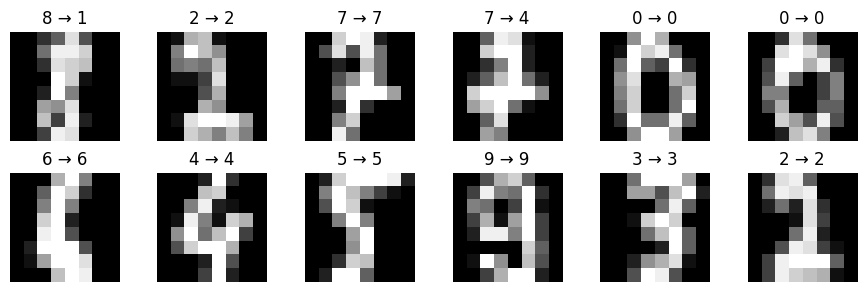

In [22]:
fig, axes = plt.subplots(2, 6, figsize=(9, 3))
for ax in axes.ravel():
    i = np.random.randint(0, len(X_test))
    img = X_test[i:i+1].to(device)

    with torch.no_grad():
        pred = model(img).argmax(1).item()

    ax.imshow(X_test[i, 0].cpu(), cmap="gray")
    ax.set_title(f"{y_test[i].item()} → {pred}")
    ax.axis("off")

plt.tight_layout()
plt.show()


## 21) Save the trained model (optional)
This saves weights so you can reuse the model later.


In [ ]:
torch.save(model.state_dict(), "cnn_digits.pth")
"Saved cnn_digits.pth"


## 22) Extension: See feature maps (optional)
This is a *visual intuition* step. We look at the first few channels after each Conv layer for a single image.

If you are short on time in the lab, skip this section.


In [ ]:
@torch.no_grad()
def show_feature_maps(one_image):
    model.eval()
    x = one_image.to(device)  # shape: (1, 1, 8, 8)

    # After Conv1 + ReLU
    x1 = feature_extractor[1](feature_extractor[0](x)).cpu()[0]  # (16, 8, 8)

    # After Pool + Conv2 + ReLU
    x_pool = feature_extractor[2](feature_extractor[1](feature_extractor[0](x)))
    x2 = feature_extractor[4](feature_extractor[3](x_pool)).cpu()[0]  # (32, 4, 4)

    def show_grid(fmaps, title):
        fig, axes = plt.subplots(2, 4, figsize=(8, 3))
        for i, ax in enumerate(axes.ravel()):
            ax.imshow(fmaps[i], cmap="gray")
            ax.axis("off")
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()

    show_grid(x1, "After Conv1 (first 8 channels)")
    show_grid(x2, "After Conv2 (first 8 channels)")

sample = X_test[0:1]
show_feature_maps(sample)
